In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

In [3]:
# loading Argo EN4 data
ds_EN4 = xr.open_dataset('../Data/EN4_regional.nc')
ds_EN4 = ds_EN4.sel(time=slice('2009-01','2014-05'))
ds_EN4_2010Feb = ds_EN4.sel(time='2010-02')
ds_EN4_2010Jul = ds_EN4.sel(time='2010-07')


# loading EnOI data
ds_hycomcci = xr.open_dataset('../Data/HYCOMcciAVG_vertEN4_2009_2013.nc')
hycomcci_monthly = xr.open_dataset('../Data/HYCOMcciAVG_vertEN4_2009_2014_monthly.nc')
hycomcci_monthly['time'].values = ds_EN4['time'].values
ds_hycomcci_2010Feb = hycomcci_monthly.sel(time='2010-02')
ds_hycomcci_2010Jul = hycomcci_monthly.sel(time='2010-07')


# loading HYCOMfree SST data
ds_hycomfree = xr.open_dataset('../Data/HYCOMfree_vertEN4_2009_2013.nc')
hycomfree_monthly = xr.open_dataset('../Data/HYCOMfreeAVG_vertEN4_2009_2014_monthly.nc')
hycomfree_monthly['time'].values = ds_EN4['time'].values
ds_hycomfree_2010Feb = hycomfree_monthly.sel(time='2010-02')
ds_hycomfree_2010Jul = hycomfree_monthly.sel(time='2010-07')

In [62]:
hycomcci_monthly

<xarray.Dataset>
Dimensions:      (depth: 42, latitude: 41, longitude: 60, time: 65)
Coordinates:
  * time         (time) datetime64[ns] 2009-01-16T12:00:00 ... 2014-05-16T12:00:00
  * longitude    (longitude) float32 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0
  * latitude     (latitude) float32 -50.0 -49.224796 ... -11.176025 -10.0
  * depth        (depth) float32 5.02159 15.07854 25.16046 ... 5050.99 5350.272
Data variables:
    mercator     int32 ...
    x            (longitude) float32 ...
    y            (latitude) float32 ...
    model_depth  (latitude, longitude) float32 ...
    salinity     (time, depth, latitude, longitude) float32 ...
    temperature  (time, depth, latitude, longitude) float32 ...
    u            (time, depth, latitude, longitude) float32 ...
    v            (time, depth, latitude, longitude) float32 ...
Attributes:
    title:                     Pilot MyOcean reanalysis by TOPAZ4 (2003-2008)
    institution:               NERSC, Thormoehlens gate 47, N-5

In [63]:
ds_EN4

<xarray.Dataset>
Dimensions:                          (bnds: 2, depth: 42, lat: 41, lon: 60, time: 65)
Coordinates:
  * depth                            (depth) float32 5.0215898 ... 5350.272
  * lat                              (lat) float32 -50.0 -49.0 ... -11.0 -10.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 2009-01-16T12:00:00 ... 2014-05-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (depth, bnds) float32 ...
    salinity                         (time, depth, lat, lon) float32 ...
    salinity_observation_weights     (time, depth, lat, lon) float32 ...
    salinity_uncertainty             (time, depth, lat, lon) float32 ...
    temperature                      (time, depth, lat, lon) float32 ...
    temperature_observation_weights  (time, depth, lat, lon) float32 ...
    temperature_uncertainty          (time, depth, lat, lon) float32

# 1. Mean vertical differences

## 1.1 Temperature

### 1.1.1.a 2009--2013 mean

In [4]:
hycomcci_temp = ds_hycomcci['temperature'].mean(dim=('time','longitude','latitude'), skipna=True)
hycomfree_temp = ds_hycomfree['temperature'].mean(dim=('time','longitude','latitude'), skipna=True)
en4_temp = ds_EN4['temperature'].mean(dim=('time','lon','lat'), skipna=True) - 273.15

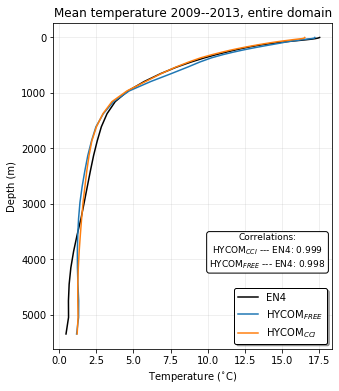

In [41]:
# # calculating correlations
corr_ccien4_sst = round(np.corrcoef(hycomcci_temp,en4_temp)[0,1],3)
corr_freeen4_sst = round(np.corrcoef(hycomfree_temp,en4_temp)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2009--2013, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean20092013_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.1.1.b 2009--2013 yearly means

In [4]:
hycomcci_temp_ann = ds_hycomcci['temperature'].mean(dim=('longitude','latitude'), skipna=True)
hycomfree_temp_ann = ds_hycomfree['temperature'].mean(dim=('longitude','latitude'), skipna=True)
en4_temp_ann = ds_EN4['temperature'].resample(time='A').mean(dim=('time','lon','lat'), skipna=True) - 273.15

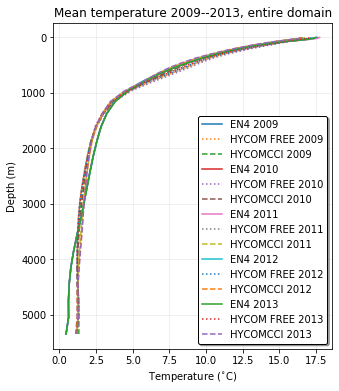

In [14]:
# # calculating correlations
# corr_ccien4_sst = round(np.corrcoef(hycomcci_temp,en4_temp)[0,1],3)
# corr_freeen4_sst = round(np.corrcoef(hycomfree_temp,en4_temp)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
for year in np.arange(0,5):
    en4_temp_ann[year].plot.line(y='depth', linestyle='solid', label='EN4 {}'.format(2009+year))
    hycomfree_temp_ann[year].plot.line(y='depth', linestyle='dotted', label='HYCOM FREE {}'.format(2009+year))
    hycomcci_temp_ann[year].plot.line(y='depth', linestyle='dashed', label='HYCOMCCI {}'.format(2009+year))
plt.title('Mean temperature 2009--2013, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

# textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
# fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
# plt.savefig('../Figures/profiles/Temp_mean20092013_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.1.2.a 2010 Feb

In [6]:
hycomcci_temp2010Feb = ds_hycomcci_2010Feb['temperature'].mean(dim=('longitude','latitude'), skipna=True)
hycomfree_temp2010Feb = ds_hycomfree_2010Feb['temperature'].mean(dim=('longitude','latitude'), skipna=True)
en4_temp2010Feb = ds_EN4_2010Feb['temperature'].mean(dim=('lon','lat'), skipna=True) - 273.15

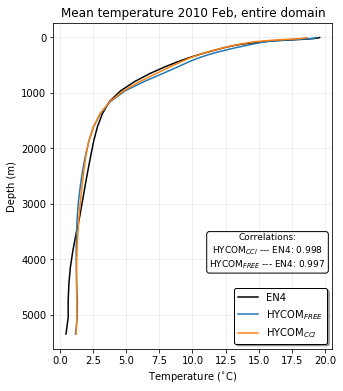

In [40]:
# # calculating correlations
corr_ccien4_sst2010Feb = round(np.corrcoef(hycomcci_temp2010Feb,en4_temp2010Feb)[0,1],3)
corr_freeen4_sst2010Feb = round(np.corrcoef(hycomfree_temp2010Feb,en4_temp2010Feb)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Feb, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Feb_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.1.2.b All Feb

In [71]:
hycomcci_tempFeb = hycomcci_monthly['temperature'].sel(time=hycomcci_monthly.time.dt.month.isin([2])).mean(dim=('longitude','latitude'), skipna=True)
hycomfree_tempFeb = hycomfree_monthly['temperature'].sel(time=hycomfree_monthly.time.dt.month.isin([2])).mean(dim=('longitude','latitude'), skipna=True)
en4_tempFeb = ds_EN4['temperature'].sel(time=ds_EN4.time.dt.month.isin([2])).mean(dim=('lon','lat'), skipna=True) - 273.15

#### HYCOM<sub>CCI</sub>

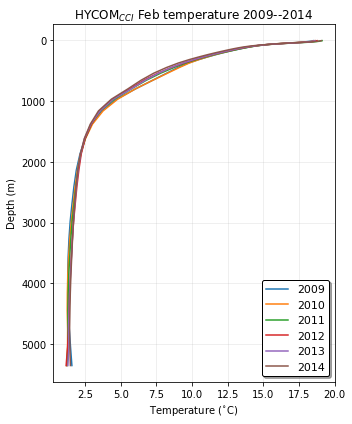

In [89]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,6):
    hycomcci_tempFeb[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{CCI}$ Feb temperature 2009--2014')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Temp_meanFeb_HYCOMcci_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### HYCOM<sub>FREE</sub>

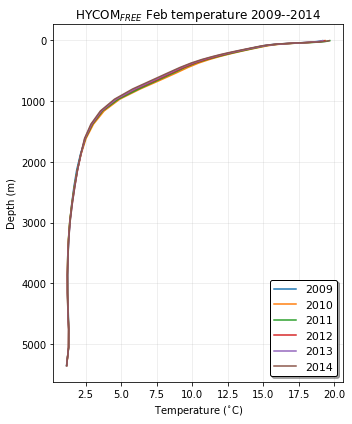

In [90]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,6):
    hycomfree_tempFeb[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{FREE}$ Feb temperature 2009--2014')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Temp_meanFeb_HYCOMfree_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### EN4

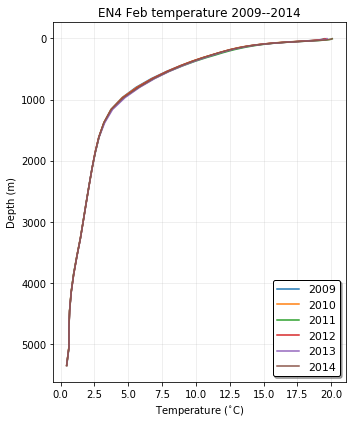

In [92]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,6):
    en4_tempFeb[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('EN4 Feb temperature 2009--2014')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Temp_meanFeb_EN4_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.1.3.a 2010 Jul

In [8]:
hycomcci_temp2010Jul = ds_hycomcci_2010Jul['temperature'].mean(dim=('longitude','latitude'), skipna=True)
hycomfree_temp2010Jul = ds_hycomfree_2010Jul['temperature'].mean(dim=('longitude','latitude'), skipna=True)
en4_temp2010Jul = ds_EN4_2010Jul['temperature'].mean(dim=('lon','lat'), skipna=True) - 273.15

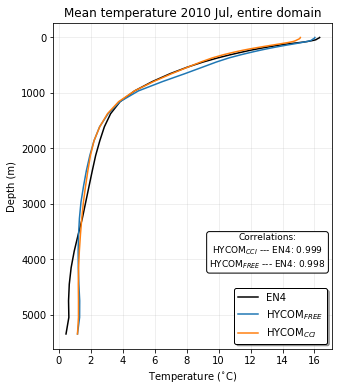

In [39]:
# # calculating correlations
corr_ccien4_sst2010Jul = round(np.corrcoef(hycomcci_temp2010Jul,en4_temp2010Jul)[0,1],3)
corr_freeen4_sst2010Jul = round(np.corrcoef(hycomfree_temp2010Jul,en4_temp2010Jul)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Jul, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Jul_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.1.3.b All Jul

In [94]:
hycomcci_tempJul = hycomcci_monthly['temperature'].sel(time=hycomcci_monthly.time.dt.month.isin([7])).mean(dim=('longitude','latitude'), skipna=True)
hycomfree_tempJul = hycomfree_monthly['temperature'].sel(time=hycomfree_monthly.time.dt.month.isin([7])).mean(dim=('longitude','latitude'), skipna=True)
en4_tempJul = ds_EN4['temperature'].sel(time=ds_EN4.time.dt.month.isin([7])).mean(dim=('lon','lat'), skipna=True) - 273.15

#### HYCOM<sub>CCI</sub>

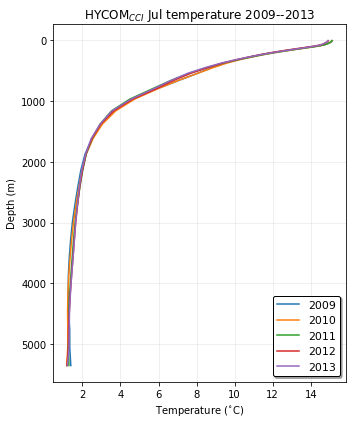

In [110]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,5):
    hycomcci_tempJul[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{CCI}$ Jul temperature 2009--2013')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Temp_meanJul_HYCOMcci_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### HYCOM<sub>FREE</sub>

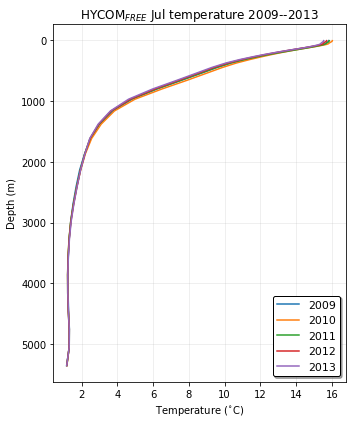

In [111]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,5):
    hycomfree_tempJul[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{FREE}$ Jul temperature 2009--2013')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Temp_meanJul_HYCOMfree_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### EN4

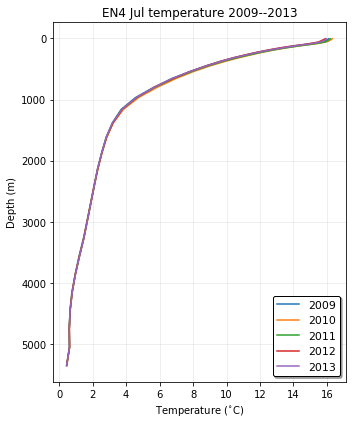

In [112]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,5):
    en4_tempJul[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('EN4 Jul temperature 2009--2013')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Temp_meanJul_EN4_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## 1.2 Salinity

### 1.2.1 2009--2013

In [10]:
hycomcci_sal = ds_hycomcci['salinity'].mean(dim=('time','longitude','latitude'), skipna=True)
hycomfree_sal = ds_hycomfree['salinity'].mean(dim=('time','longitude','latitude'), skipna=True)
en4_sal = ds_EN4['salinity'].mean(dim=('time','lon','lat'), skipna=True)

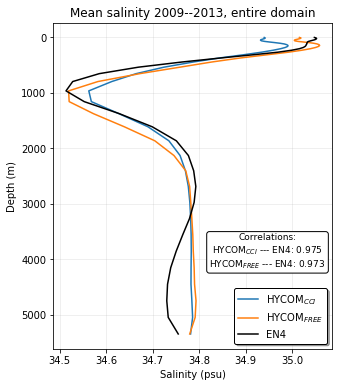

In [19]:
# # calculating correlations
corr_ccien4_sal = round(np.corrcoef(hycomcci_sal,en4_sal)[0,1],3)
corr_freeen4_sal = round(np.corrcoef(hycomfree_sal,en4_sal)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
hycomcci_sal.plot.line(y='depth',label='HYCOM$_{CCI}$')
hycomfree_sal.plot.line(y='depth',label='HYCOM$_{FREE}$')
en4_sal.plot.line(y='depth', color='k', label='EN4')
plt.title('Mean salinity 2009--2013, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean20092013_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.2.2.a 2010 Feb

In [21]:
hycomcci_sal2010Feb = ds_hycomcci_2010Feb['salinity'].mean(dim=('time','longitude','latitude'), skipna=True)
hycomfree_sal2010Feb = ds_hycomfree_2010Feb['salinity'].mean(dim=('time','longitude','latitude'), skipna=True)
en4_sal2010Feb = ds_EN4_2010Feb['salinity'].mean(dim=('time','lon','lat'), skipna=True)

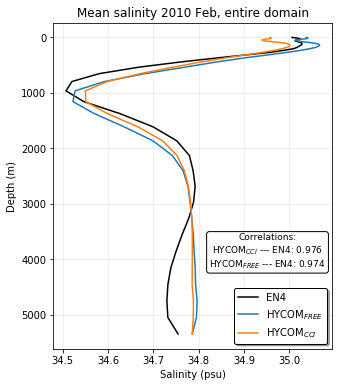

In [23]:
# # calculating correlations
corr_ccien4_sal2010Feb = round(np.corrcoef(hycomcci_sal2010Feb,en4_sal2010Feb)[0,1],3)
corr_freeen4_sal2010Feb = round(np.corrcoef(hycomfree_sal2010Feb,en4_sal2010Feb)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Feb, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Feb_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.2.2.b All Feb

In [113]:
hycomcci_salFeb = hycomcci_monthly['salinity'].sel(time=hycomcci_monthly.time.dt.month.isin([2])).mean(dim=('longitude','latitude'), skipna=True)
hycomfree_salFeb = hycomfree_monthly['salinity'].sel(time=hycomfree_monthly.time.dt.month.isin([2])).mean(dim=('longitude','latitude'), skipna=True)
en4_salFeb = ds_EN4['salinity'].sel(time=ds_EN4.time.dt.month.isin([2])).mean(dim=('lon','lat'), skipna=True)

#### HYCOM<sub>CCI</sub>

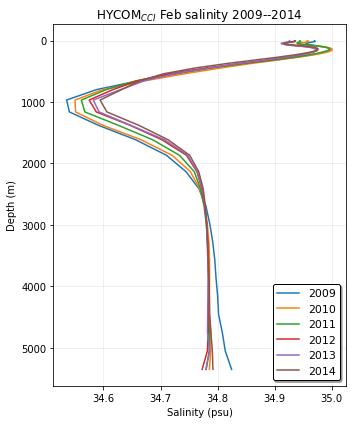

In [105]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,6):
    hycomcci_salFeb[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{CCI}$ Feb salinity 2009--2014')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Sal_meanFeb_HYCOMcci_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### HYCOM<sub>FREE</sub>

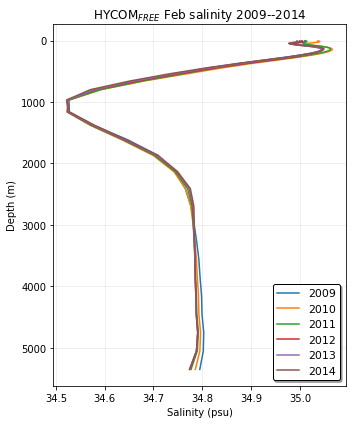

In [107]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,6):
    hycomfree_salFeb[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{FREE}$ Feb salinity 2009--2014')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Sal_meanFeb_HYCOMfree_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### EN4

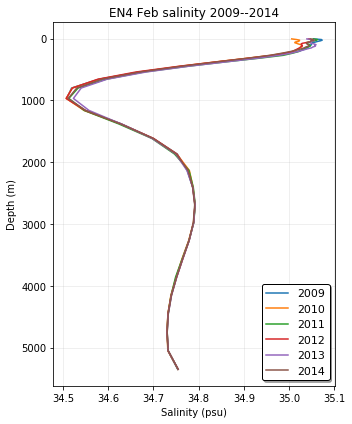

In [114]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,6):
    en4_salFeb[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('EN4 Feb salinity 2009--2014')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Sal_meanFeb_EN4_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.2.3.a 2010 Jul

In [24]:
hycomcci_sal2010Jul = ds_hycomcci_2010Jul['salinity'].mean(dim=('time','longitude','latitude'), skipna=True)
hycomfree_sal2010Jul = ds_hycomfree_2010Jul['salinity'].mean(dim=('time','longitude','latitude'), skipna=True)
en4_sal2010Jul = ds_EN4_2010Jul['salinity'].mean(dim=('time','lon','lat'), skipna=True)

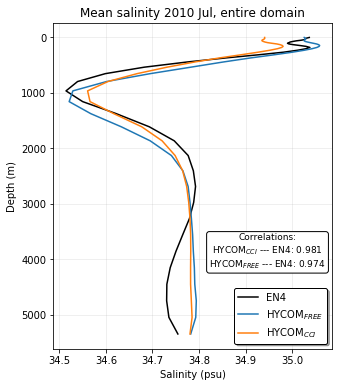

In [26]:
# # calculating correlations
corr_ccien4_sal2010Jul = round(np.corrcoef(hycomcci_sal2010Jul,en4_sal2010Jul)[0,1],3)
corr_freeen4_sal2010Jul = round(np.corrcoef(hycomfree_sal2010Jul,en4_sal2010Jul)[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Jul, entire domain')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Jul_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 1.2.3.b All Jul

In [115]:
hycomcci_salJul = hycomcci_monthly['salinity'].sel(time=hycomcci_monthly.time.dt.month.isin([7])).mean(dim=('longitude','latitude'), skipna=True)
hycomfree_salJul = hycomfree_monthly['salinity'].sel(time=hycomfree_monthly.time.dt.month.isin([7])).mean(dim=('longitude','latitude'), skipna=True)
en4_salJul = ds_EN4['salinity'].sel(time=ds_EN4.time.dt.month.isin([7])).mean(dim=('lon','lat'), skipna=True)

#### HYCOM<sub>CCI</sub>

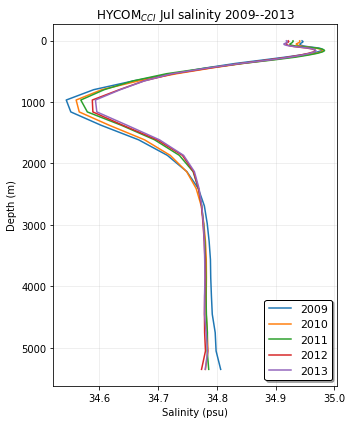

In [117]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,5):
    hycomcci_salJul[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{CCI}$ Jul salinity 2009--2013')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Sal_meanJul_HYCOMcci_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### HYCOM<sub>FREE</sub>

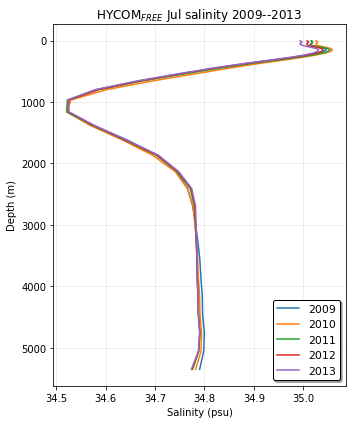

In [119]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,5):
    hycomfree_salJul[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('HYCOM$_{FREE}$ Jul salinity 2009--2013')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Sal_meanJul_HYCOMfree_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

#### EN4

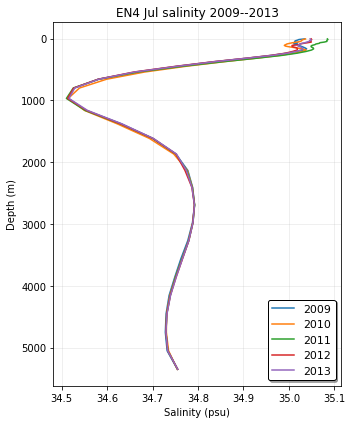

In [121]:
fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()

for year in np.arange(0,5):
    en4_salJul[year].plot.line(y='depth', linestyle='solid', label='{}'.format(2009+year))
plt.title('EN4 Jul salinity 2009--2013')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)
# plt.xlim(-1.05,1.05)
# plt.ylim(300,0)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.tight_layout()
plt.savefig('../Figures/profiles/Sal_meanJul_EN4_domain.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

# 2. Select vertical differences

## Locations

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


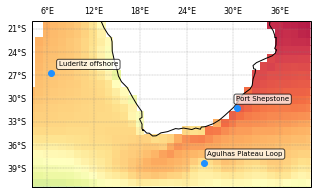

<Figure size 432x288 with 0 Axes>

In [20]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_extent((4, 40, -40, -20))

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

### plotting timeseries locations ##########################################################################
# Port Shepstone current core
ax.plot(30.50, -31.23, color='dodgerblue', marker='o', markersize=6, transform=ccrs.PlateCarree())
ax.text(30.39, -30.33, 'Port Shepstone', transform=ccrs.PlateCarree(), fontsize=7, bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

# Agulhas Plateau Loop
ax.plot(26.27, -38.31, color='dodgerblue', marker='o', markersize=6, transform=ccrs.PlateCarree())
ax.text(26.67, -37.41, 'Agulhas Plateau Loop', transform=ccrs.PlateCarree(), fontsize=7, bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

# Agulhas Bank
# ax.plot(21.05, -35.21, color='dodgerblue', marker='o', markersize=6, transform=ccrs.PlateCarree())
# ax.text(13.95, -35.21, 'Agulhas Bank', transform=ccrs.PlateCarree(), fontsize=7, bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

# Luderitz cell
# ax.plot(14.0, -26.64, color='dodgerblue', marker='o', markersize=6, transform=ccrs.PlateCarree())
# ax.text(15.50, -27.84, 'Luderitz cell', transform=ccrs.PlateCarree(), fontsize=7, bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

# Luderitz offshore
ax.plot(6.50, -26.64, color='dodgerblue', marker='o', markersize=6, transform=ccrs.PlateCarree())
ax.text(7.50, -25.84, 'Luderitz offshore', transform=ccrs.PlateCarree(), fontsize=7, bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

###########################################################################################################

# img = ds_EN4['temperature'].mean('time')[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Spectral_r'), add_colorbar=False)
img = ds_hycomcci['temperature'].mean('time')[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Spectral_r'), add_colorbar=False)
# cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
# cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.savefig('../Figures/reference/Proflies_locations.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

## 2.1 Port Shepstone

## =========== Temperature =============

### 2.1.1 Temperature 2009-2013 Mean

In [27]:
hycomcci_temp_ps = ds_hycomcci['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_ps = hycomcci_temp_ps.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

hycomfree_temp_ps = ds_hycomfree['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_ps = hycomfree_temp_ps.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

en4_temp_ps = ds_EN4['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_ps = en4_temp_ps.sel(lat=(-31.23),lon=(30.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


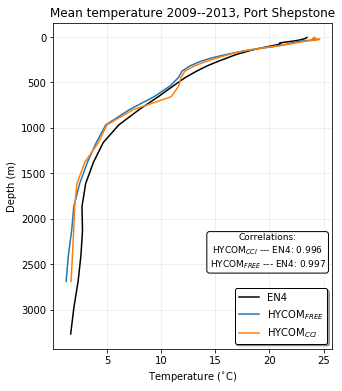

In [38]:
# # calculating correlations
corr_ccien4_sst_ps = round(np.corrcoef(hycomcci_temp_ps[:-9],en4_temp_ps[:-9])[0,1],3)
corr_freeen4_sst_ps = round(np.corrcoef(hycomfree_temp_ps[:-9],en4_temp_ps[:-9])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_ps.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_ps.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_ps.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2009--2013, Port Shepstone')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst_ps) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst_ps)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean20092013_PortShepstone.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.1.2 Temperature 2010 Feb

In [30]:
hycomcci_temp_ps_2010Feb = ds_hycomcci_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_ps_2010Feb = hycomcci_temp_ps_2010Feb.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

hycomfree_temp_ps_2010Feb = ds_hycomfree_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_ps_2010Feb = hycomfree_temp_ps_2010Feb.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

en4_temp_ps_2010Feb = ds_EN4_2010Feb['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_ps_2010Feb = en4_temp_ps_2010Feb.sel(lat=(-31.23),lon=(30.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


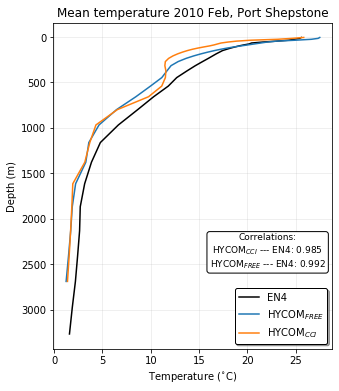

In [37]:
# # calculating correlations
corr_ccien4_sst_ps_2010Feb = round(np.corrcoef(hycomcci_temp_ps_2010Feb[:-9],en4_temp_ps_2010Feb[:-9])[0,1],3)
corr_freeen4_sst_ps_2010Feb = round(np.corrcoef(hycomfree_temp_ps_2010Feb[:-9],en4_temp_ps_2010Feb[:-9])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_ps_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_ps_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_ps_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Feb, Port Shepstone')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst_ps_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst_ps_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Feb_PortShepstone.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.1.3 Temperature 2010 Jul

In [33]:
hycomcci_temp_ps_2010Jul = ds_hycomcci_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_ps_2010Jul = hycomcci_temp_ps_2010Jul.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

hycomfree_temp_ps_2010Jul = ds_hycomfree_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_ps_2010Jul = hycomfree_temp_ps_2010Jul.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

en4_temp_ps_2010Jul = ds_EN4_2010Jul['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_ps_2010Jul = en4_temp_ps_2010Jul.sel(lat=(-31.23),lon=(30.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


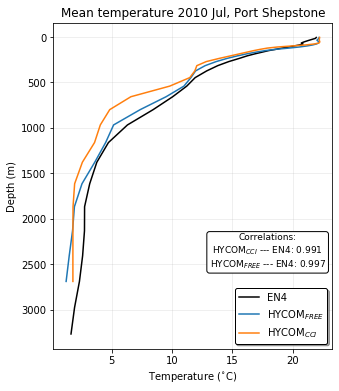

In [36]:
# # calculating correlations
corr_ccien4_sst_ps_2010Jul = round(np.corrcoef(hycomcci_temp_ps_2010Jul[:-9],en4_temp_ps_2010Jul[:-9])[0,1],3)
corr_freeen4_sst_ps_2010Jul = round(np.corrcoef(hycomfree_temp_ps_2010Jul[:-9],en4_temp_ps_2010Jul[:-9])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_ps_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_ps_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_ps_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Jul, Port Shepstone')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sst_ps_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sst_ps_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Jul_PortShepstone.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## =========== Salinity =============

### 2.1.4 Salinity 2009-2013 Mean

In [46]:
hycomcci_sal_ps = ds_hycomcci['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_ps = hycomcci_sal_ps.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

hycomfree_sal_ps = ds_hycomfree['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_ps = hycomfree_sal_ps.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

en4_sal_ps = ds_EN4['salinity'].mean(dim=('time'), skipna=True)
en4_sal_ps = en4_sal_ps.sel(lat=(-31.23),lon=(30.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


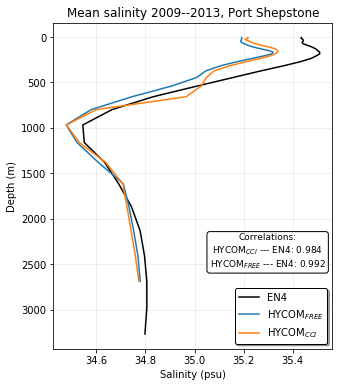

In [89]:
# # calculating correlations
corr_ccien4_sal_ps = round(np.corrcoef(hycomcci_sal_ps[:-9],en4_sal_ps[:-9])[0,1],3)
corr_freeen4_sal_ps = round(np.corrcoef(hycomfree_sal_ps[:-9],en4_sal_ps[:-9])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_ps.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_ps.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_ps.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2009--2013, Port Shepstone')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_ps) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_ps)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean20092013_PortShepstone.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.1.5 Salinity 2010 Feb

In [50]:
hycomcci_sal_ps_2010Feb = ds_hycomcci_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_ps_2010Feb = hycomcci_sal_ps_2010Feb.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

hycomfree_sal_ps_2010Feb = ds_hycomfree_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_ps_2010Feb = hycomfree_sal_ps_2010Feb.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

en4_sal_ps_2010Feb = ds_EN4_2010Feb['salinity'].mean(dim=('time'), skipna=True)
en4_sal_ps_2010Feb = en4_sal_ps_2010Feb.sel(lat=(-31.23),lon=(30.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


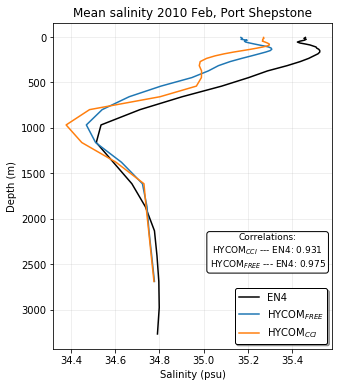

In [90]:
# # calculating correlations
corr_ccien4_sal_ps_2010Feb = round(np.corrcoef(hycomcci_sal_ps_2010Feb[:-9],en4_sal_ps_2010Feb[:-9])[0,1],3)
corr_freeen4_sal_ps_2010Feb = round(np.corrcoef(hycomfree_sal_ps_2010Feb[:-9],en4_sal_ps_2010Feb[:-9])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_ps_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_ps_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_ps_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Feb, Port Shepstone')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_ps_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_ps_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Feb_PortShepstone.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.1.6 Salinity 2010 Jul

In [56]:
hycomcci_sal_ps_2010Jul = ds_hycomcci_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_ps_2010Jul = hycomcci_sal_ps_2010Jul.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

hycomfree_sal_ps_2010Jul = ds_hycomfree_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_ps_2010Jul = hycomfree_sal_ps_2010Jul.sel(latitude=(-31.23),longitude=(30.50), method='nearest')

en4_sal_ps_2010Jul = ds_EN4_2010Jul['salinity'].mean(dim=('time'), skipna=True)
en4_sal_ps_2010Jul = en4_sal_ps_2010Jul.sel(lat=(-31.23),lon=(30.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


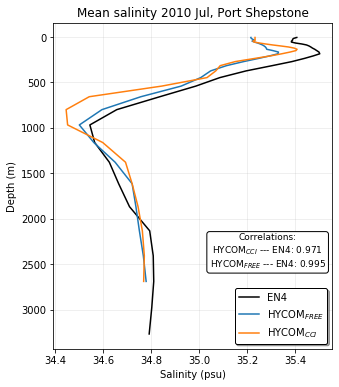

In [91]:
# # calculating correlations
corr_ccien4_sal_ps_2010Jul = round(np.corrcoef(hycomcci_sal_ps_2010Jul[:-9],en4_sal_ps_2010Jul[:-9])[0,1],3)
corr_freeen4_sal_ps_2010Jul = round(np.corrcoef(hycomfree_sal_ps_2010Jul[:-9],en4_sal_ps_2010Jul[:-9])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_ps_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_ps_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_ps_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Jul, Port Shepstone')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_ps_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_ps_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Jul_PortShepstone.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## 2.2 Agulhas Plateau Loop

## =========== Temperature =============

### 2.2.1 Temperature 2009-2013 Mean

In [62]:
# 26.27, -38.31
hycomcci_temp_apl = ds_hycomcci['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_apl = hycomcci_temp_apl.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

hycomfree_temp_apl = ds_hycomfree['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_apl = hycomfree_temp_apl.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

en4_temp_apl = ds_EN4['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_apl = en4_temp_apl.sel(lat=(-38.31),lon=(26.27), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


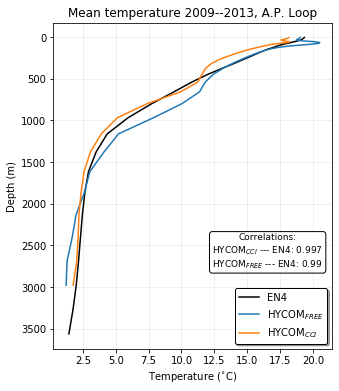

In [67]:
# # calculating correlations
corr_ccien4_temp_apl = round(np.corrcoef(hycomcci_temp_apl[:-8],en4_temp_apl[:-8])[0,1],3)
corr_freeen4_temp_apl = round(np.corrcoef(hycomfree_temp_apl[:-8],en4_temp_apl[:-8])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_apl.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_apl.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_apl.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2009--2013, A.P. Loop')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_apl) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_apl)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean20092013_AgulhasPlateauLoop.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.2.2 Temperature 2010 Feb

In [69]:
hycomcci_temp_apl_2010Feb = ds_hycomcci_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_apl_2010Feb = hycomcci_temp_apl_2010Feb.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

hycomfree_temp_apl_2010Feb = ds_hycomfree_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_apl_2010Feb = hycomfree_temp_apl_2010Feb.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

en4_temp_apl_2010Feb = ds_EN4_2010Feb['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_apl_2010Feb = en4_temp_apl_2010Feb.sel(lat=(-38.31),lon=(26.27), method='nearest')

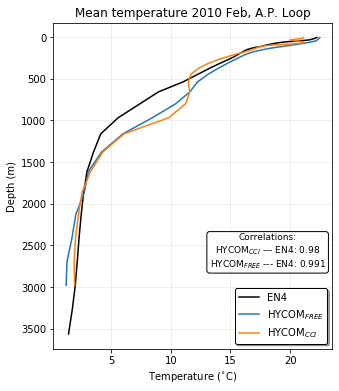

In [72]:
# # calculating correlations
corr_ccien4_temp_apl_2010Feb = round(np.corrcoef(hycomcci_temp_apl_2010Feb[:-8],en4_temp_apl_2010Feb[:-8])[0,1],3)
corr_freeen4_temp_apl_2010Feb = round(np.corrcoef(hycomfree_temp_apl_2010Feb[:-8],en4_temp_apl_2010Feb[:-8])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_apl_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_apl_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_apl_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Feb, A.P. Loop')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_apl_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_apl_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Feb_AgulhasPlateauLoop.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.2.3 Temperature 2010 Jul

In [73]:
hycomcci_temp_apl_2010Jul = ds_hycomcci_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_apl_2010Jul = hycomcci_temp_apl_2010Jul.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

hycomfree_temp_apl_2010Jul = ds_hycomfree_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_apl_2010Jul = hycomfree_temp_apl_2010Jul.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

en4_temp_apl_2010Jul = ds_EN4_2010Jul['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_apl_2010Jul = en4_temp_apl_2010Jul.sel(lat=(-38.31),lon=(26.27), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


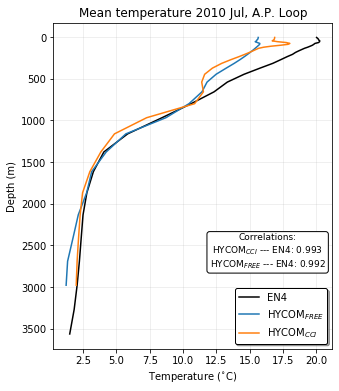

In [76]:
# # calculating correlations
corr_ccien4_temp_apl_2010Jul = round(np.corrcoef(hycomcci_temp_apl_2010Jul[:-8],en4_temp_apl_2010Jul[:-8])[0,1],3)
corr_freeen4_temp_apl_2010Jul = round(np.corrcoef(hycomfree_temp_apl_2010Jul[:-8],en4_temp_apl_2010Jul[:-8])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_apl_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_apl_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_apl_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Jul, A.P. Loop')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_apl_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_apl_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Jul_AgulhasPlateauLoop.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## =========== Salinity =============

### 2.2.4 Salinity 2009-2013 Mean

In [78]:
hycomcci_sal_apl = ds_hycomcci['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_apl = hycomcci_sal_apl.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

hycomfree_sal_apl = ds_hycomfree['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_apl = hycomfree_sal_apl.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

en4_sal_apl = ds_EN4['salinity'].mean(dim=('time'), skipna=True)
en4_sal_apl = en4_sal_apl.sel(lat=(-38.31),lon=(26.27), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


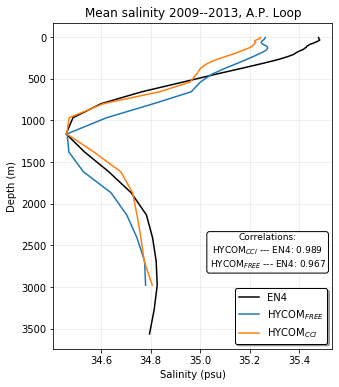

In [92]:
# # calculating correlations
corr_ccien4_sal_apl = round(np.corrcoef(hycomcci_sal_apl[:-8],en4_sal_apl[:-8])[0,1],3)
corr_freeen4_sal_apl = round(np.corrcoef(hycomfree_sal_apl[:-8],en4_sal_apl[:-8])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_apl.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_apl.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_apl.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2009--2013, A.P. Loop')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_apl) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_apl)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean20092013_AgulhasPlateauLoop.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.2.5 Salinity 2010 Feb

In [84]:
hycomcci_sal_apl_2010Feb = ds_hycomcci_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_apl_2010Feb = hycomcci_sal_apl_2010Feb.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

hycomfree_sal_apl_2010Feb = ds_hycomfree_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_apl_2010Feb = hycomfree_sal_apl_2010Feb.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

en4_sal_apl_2010Feb = ds_EN4_2010Feb['salinity'].mean(dim=('time'), skipna=True)
en4_sal_apl_2010Feb = en4_sal_apl_2010Feb.sel(lat=(-38.31),lon=(26.27), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


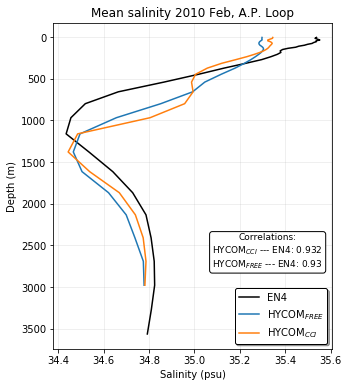

In [93]:
# # calculating correlations
corr_ccien4_sal_apl_2010Feb = round(np.corrcoef(hycomcci_sal_apl_2010Feb[:-8],en4_sal_apl_2010Feb[:-8])[0,1],3)
corr_freeen4_sal_apl_2010Feb = round(np.corrcoef(hycomfree_sal_apl_2010Feb[:-8],en4_sal_apl_2010Feb[:-8])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_apl_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_apl_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_apl_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Feb, A.P. Loop')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_apl_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_apl_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Feb_AgulhasPlateauLoop.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.2.6 Salinity 2010 Jul

In [87]:
hycomcci_sal_apl_2010Jul = ds_hycomcci_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_apl_2010Jul = hycomcci_sal_apl_2010Jul.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

hycomfree_sal_apl_2010Jul = ds_hycomfree_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_apl_2010Jul = hycomfree_sal_apl_2010Jul.sel(latitude=(-38.31),longitude=(26.27), method='nearest')

en4_sal_apl_2010Jul = ds_EN4_2010Jul['salinity'].mean(dim=('time'), skipna=True)
en4_sal_apl_2010Jul = en4_sal_apl_2010Jul.sel(lat=(-38.31),lon=(26.27), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


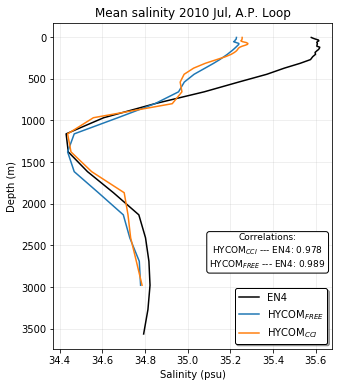

In [95]:
# # calculating correlations
corr_ccien4_sal_apl_2010Jul = round(np.corrcoef(hycomcci_sal_apl_2010Jul[:-8],en4_sal_apl_2010Jul[:-8])[0,1],3)
corr_freeen4_sal_apl_2010Jul = round(np.corrcoef(hycomfree_sal_apl_2010Jul[:-8],en4_sal_apl_2010Jul[:-8])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_apl_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_apl_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_apl_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Jul, A.P. Loop')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_apl_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_apl_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Jul_AgulhasPlateauLoop.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## 2.3 Luderitz offshore

## =========== Temperature =============

### 2.3.1 Temperature 2009-2013 Mean

In [100]:
# 6.50, -26.64
hycomcci_temp_lo = ds_hycomcci['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_lo = hycomcci_temp_lo.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_temp_lo = ds_hycomfree['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_lo = hycomfree_temp_lo.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_temp_lo = ds_EN4['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_lo = en4_temp_lo.sel(lat=(-26.64),lon=(6.50), method='nearest')

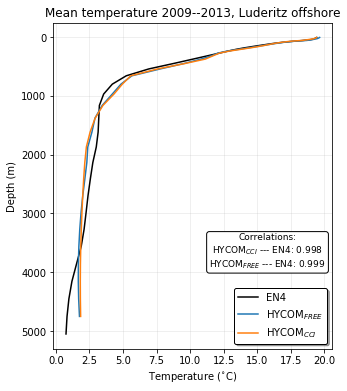

In [106]:
# # calculating correlations
corr_ccien4_temp_lo = round(np.corrcoef(hycomcci_temp_lo[:-2],en4_temp_lo[:-2])[0,1],3)
corr_freeen4_temp_lo = round(np.corrcoef(hycomfree_temp_lo[:-2],en4_temp_lo[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_lo.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_lo.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_lo.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2009--2013, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_lo) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_lo)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean20092013_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.2 Temperature 2010 Feb

In [107]:
hycomcci_temp_lo_2010Feb = ds_hycomcci_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_lo_2010Feb = hycomcci_temp_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_temp_lo_2010Feb = ds_hycomfree_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_lo_2010Feb = hycomfree_temp_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_temp_lo_2010Feb = ds_EN4_2010Feb['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_lo_2010Feb = en4_temp_lo_2010Feb.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


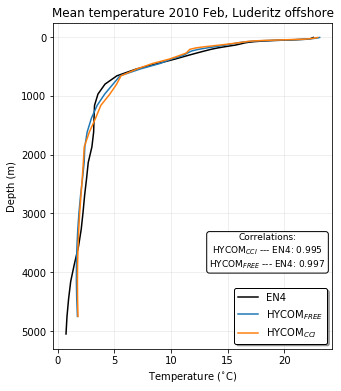

In [109]:
# # calculating correlations
corr_ccien4_temp_lo_2010Feb = round(np.corrcoef(hycomcci_temp_lo_2010Feb[:-2],en4_temp_lo_2010Feb[:-2])[0,1],3)
corr_freeen4_temp_lo_2010Feb = round(np.corrcoef(hycomfree_temp_lo_2010Feb[:-2],en4_temp_lo_2010Feb[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_lo_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Feb, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_lo_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_lo_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Feb_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.3 Temperature 2010 Jul

In [110]:
hycomcci_temp_lo_2010Jul = ds_hycomcci_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_lo_2010Jul = hycomcci_temp_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_temp_lo_2010Jul = ds_hycomfree_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_lo_2010Jul = hycomfree_temp_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_temp_lo_2010Jul = ds_EN4_2010Jul['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_lo_2010Jul = en4_temp_lo_2010Jul.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


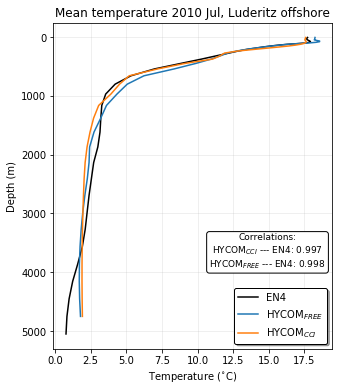

In [112]:
# # calculating correlations
corr_ccien4_temp_lo_2010Jul = round(np.corrcoef(hycomcci_temp_lo_2010Jul[:-2],en4_temp_lo_2010Jul[:-2])[0,1],3)
corr_freeen4_temp_lo_2010Jul = round(np.corrcoef(hycomfree_temp_lo_2010Jul[:-2],en4_temp_lo_2010Jul[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_lo_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Jul, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_lo_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_lo_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Jul_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## =========== Salinity =============

### 2.3.4 Salinity 2009-2013 Mean

In [113]:
hycomcci_sal_lo = ds_hycomcci['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_lo = hycomcci_sal_lo.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_sal_lo = ds_hycomfree['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_lo = hycomfree_sal_lo.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_sal_lo = ds_EN4['salinity'].mean(dim=('time'), skipna=True)
en4_sal_lo = en4_sal_lo.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


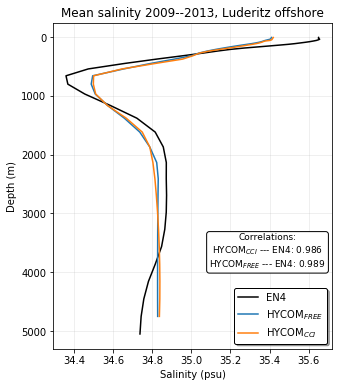

In [115]:
# # calculating correlations
corr_ccien4_sal_lo = round(np.corrcoef(hycomcci_sal_lo[:-2],en4_sal_lo[:-2])[0,1],3)
corr_freeen4_sal_lo = round(np.corrcoef(hycomfree_sal_lo[:-2],en4_sal_lo[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_lo.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_lo.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_lo.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2009--2013, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_lo) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_lo)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean20092013_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.5 Salinity 2010 Feb

In [117]:
hycomcci_sal_lo_2010Feb = ds_hycomcci_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_lo_2010Feb = hycomcci_sal_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_sal_lo_2010Feb = ds_hycomfree_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_lo_2010Feb = hycomfree_sal_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_sal_lo_2010Feb = ds_EN4_2010Feb['salinity'].mean(dim=('time'), skipna=True)
en4_sal_lo_2010Feb = en4_sal_lo_2010Feb.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


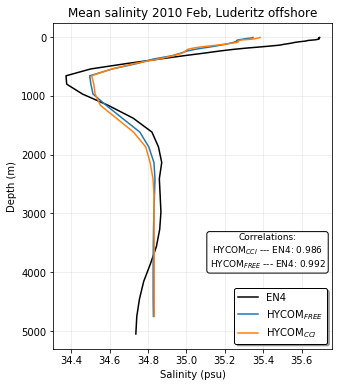

In [119]:
# # calculating correlations
corr_ccien4_sal_lo_2010Feb = round(np.corrcoef(hycomcci_sal_lo_2010Feb[:-2],en4_sal_lo_2010Feb[:-2])[0,1],3)
corr_freeen4_sal_lo_2010Feb = round(np.corrcoef(hycomfree_sal_lo_2010Feb[:-2],en4_sal_lo_2010Feb[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_lo_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Feb, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_lo_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_lo_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Feb_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.6 Salinity 2010 Jul

In [120]:
hycomcci_sal_lo_2010Jul = ds_hycomcci_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_lo_2010Jul = hycomcci_sal_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_sal_lo_2010Jul = ds_hycomfree_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_lo_2010Jul = hycomfree_sal_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_sal_lo_2010Jul = ds_EN4_2010Jul['salinity'].mean(dim=('time'), skipna=True)
en4_sal_lo_2010Jul = en4_sal_lo_2010Jul.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


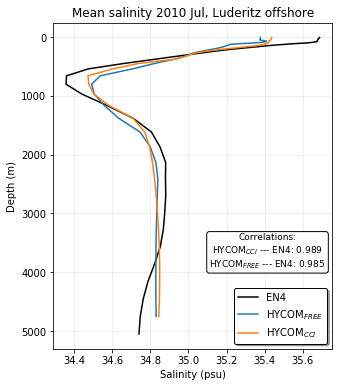

In [122]:
# # calculating correlations
corr_ccien4_sal_lo_2010Jul = round(np.corrcoef(hycomcci_sal_lo_2010Jul[:-2],en4_sal_lo_2010Jul[:-2])[0,1],3)
corr_freeen4_sal_lo_2010Jul = round(np.corrcoef(hycomfree_sal_lo_2010Jul[:-2],en4_sal_lo_2010Jul[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_lo_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Jul, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_lo_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_lo_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Jul_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## 2.4 Luderitz cell

## =========== Temperature =============

### 2.4.1 Temperature 2009-2013 Mean

In [16]:
# 6.50, -26.64
hycomcci_temp_lc = ds_hycomcci['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_lc = hycomcci_temp_lc.sel(latitude=(-26.64),longitude=(14.0), method='nearest')

hycomfree_temp_lc = ds_hycomfree['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_lc = hycomfree_temp_lc.sel(latitude=(-26.64),longitude=(14.0), method='nearest')

en4_temp_lc = ds_EN4['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_lc = en4_temp_lc.sel(lat=(-26.64),lon=(14.0), method='nearest')

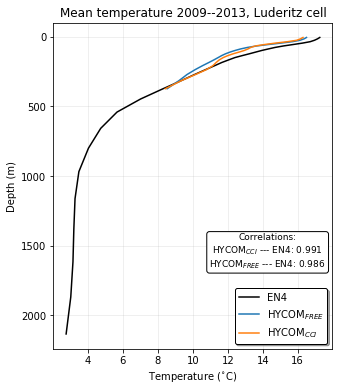

In [17]:
# # calculating correlations
corr_ccien4_temp_lc = round(np.corrcoef(hycomcci_temp_lc[:-21],en4_temp_lc[:-21])[0,1],3)
corr_freeen4_temp_lc = round(np.corrcoef(hycomfree_temp_lc[:-21],en4_temp_lc[:-21])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_lc.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_lc.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_lc.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2009--2013, Luderitz cell')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_lc) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_lc)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
# plt.savefig('../Figures/profiles/Temp_mean20092013_LuderitzCell.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.2 Temperature 2010 Feb

In [107]:
hycomcci_temp_lo_2010Feb = ds_hycomcci_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_lo_2010Feb = hycomcci_temp_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_temp_lo_2010Feb = ds_hycomfree_2010Feb['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_lo_2010Feb = hycomfree_temp_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_temp_lo_2010Feb = ds_EN4_2010Feb['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_lo_2010Feb = en4_temp_lo_2010Feb.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


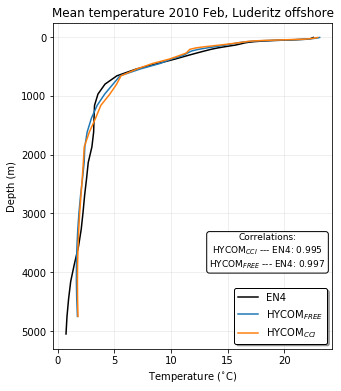

In [109]:
# # calculating correlations
corr_ccien4_temp_lo_2010Feb = round(np.corrcoef(hycomcci_temp_lo_2010Feb[:-2],en4_temp_lo_2010Feb[:-2])[0,1],3)
corr_freeen4_temp_lo_2010Feb = round(np.corrcoef(hycomfree_temp_lo_2010Feb[:-2],en4_temp_lo_2010Feb[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_lo_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Feb, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_lo_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_lo_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Feb_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.3 Temperature 2010 Jul

In [110]:
hycomcci_temp_lo_2010Jul = ds_hycomcci_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomcci_temp_lo_2010Jul = hycomcci_temp_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_temp_lo_2010Jul = ds_hycomfree_2010Jul['temperature'].mean(dim=('time'), skipna=True)
hycomfree_temp_lo_2010Jul = hycomfree_temp_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_temp_lo_2010Jul = ds_EN4_2010Jul['temperature'].mean(dim=('time'), skipna=True) - 273.15
en4_temp_lo_2010Jul = en4_temp_lo_2010Jul.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


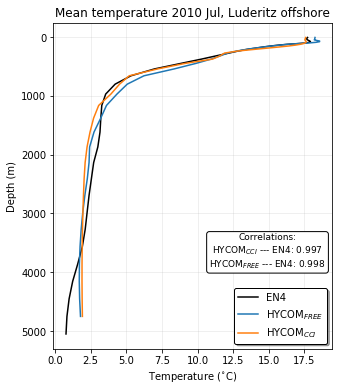

In [112]:
# # calculating correlations
corr_ccien4_temp_lo_2010Jul = round(np.corrcoef(hycomcci_temp_lo_2010Jul[:-2],en4_temp_lo_2010Jul[:-2])[0,1],3)
corr_freeen4_temp_lo_2010Jul = round(np.corrcoef(hycomfree_temp_lo_2010Jul[:-2],en4_temp_lo_2010Jul[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_temp_lo_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_temp_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_temp_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean temperature 2010 Jul, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_temp_lo_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_temp_lo_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Temp_mean2010Jul_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

## =========== Salinity =============

### 2.3.4 Salinity 2009-2013 Mean

In [113]:
hycomcci_sal_lo = ds_hycomcci['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_lo = hycomcci_sal_lo.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_sal_lo = ds_hycomfree['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_lo = hycomfree_sal_lo.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_sal_lo = ds_EN4['salinity'].mean(dim=('time'), skipna=True)
en4_sal_lo = en4_sal_lo.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


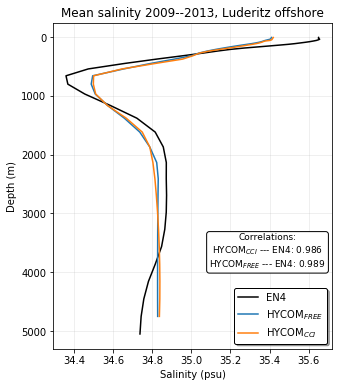

In [115]:
# # calculating correlations
corr_ccien4_sal_lo = round(np.corrcoef(hycomcci_sal_lo[:-2],en4_sal_lo[:-2])[0,1],3)
corr_freeen4_sal_lo = round(np.corrcoef(hycomfree_sal_lo[:-2],en4_sal_lo[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_lo.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_lo.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_lo.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2009--2013, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_lo) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_lo)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean20092013_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.5 Salinity 2010 Feb

In [117]:
hycomcci_sal_lo_2010Feb = ds_hycomcci_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_lo_2010Feb = hycomcci_sal_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_sal_lo_2010Feb = ds_hycomfree_2010Feb['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_lo_2010Feb = hycomfree_sal_lo_2010Feb.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_sal_lo_2010Feb = ds_EN4_2010Feb['salinity'].mean(dim=('time'), skipna=True)
en4_sal_lo_2010Feb = en4_sal_lo_2010Feb.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


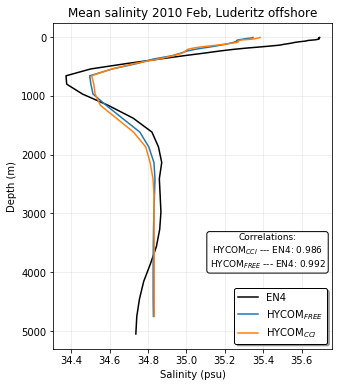

In [119]:
# # calculating correlations
corr_ccien4_sal_lo_2010Feb = round(np.corrcoef(hycomcci_sal_lo_2010Feb[:-2],en4_sal_lo_2010Feb[:-2])[0,1],3)
corr_freeen4_sal_lo_2010Feb = round(np.corrcoef(hycomfree_sal_lo_2010Feb[:-2],en4_sal_lo_2010Feb[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_lo_2010Feb.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_lo_2010Feb.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Feb, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_lo_2010Feb) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_lo_2010Feb)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Feb_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### 2.3.6 Salinity 2010 Jul

In [120]:
hycomcci_sal_lo_2010Jul = ds_hycomcci_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomcci_sal_lo_2010Jul = hycomcci_sal_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

hycomfree_sal_lo_2010Jul = ds_hycomfree_2010Jul['salinity'].mean(dim=('time'), skipna=True)
hycomfree_sal_lo_2010Jul = hycomfree_sal_lo_2010Jul.sel(latitude=(-26.64),longitude=(6.50), method='nearest')

en4_sal_lo_2010Jul = ds_EN4_2010Jul['salinity'].mean(dim=('time'), skipna=True)
en4_sal_lo_2010Jul = en4_sal_lo_2010Jul.sel(lat=(-26.64),lon=(6.50), method='nearest')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


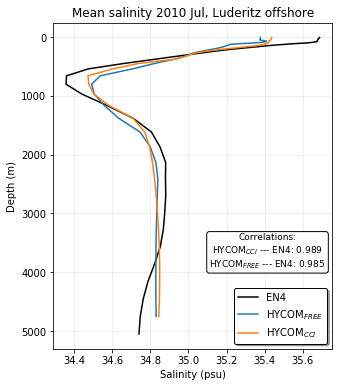

In [122]:
# # calculating correlations
corr_ccien4_sal_lo_2010Jul = round(np.corrcoef(hycomcci_sal_lo_2010Jul[:-2],en4_sal_lo_2010Jul[:-2])[0,1],3)
corr_freeen4_sal_lo_2010Jul = round(np.corrcoef(hycomfree_sal_lo_2010Jul[:-2],en4_sal_lo_2010Jul[:-2])[0,1],3)

fig = plt.figure(figsize=(5,6))
plt.gca().invert_yaxis()
en4_sal_lo_2010Jul.plot.line(y='depth', color='k', label='EN4')
hycomfree_sal_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{FREE}$')
hycomcci_sal_lo_2010Jul.plot.line(y='depth',label='HYCOM$_{CCI}$')
plt.title('Mean salinity 2010 Jul, Luderitz offshore')
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (psu)')
plt.grid(axis='both', alpha=0.25)

textbox = 'Correlations:\nHYCOM$_{CCI}$ --- EN4: ' + '{0}'.format(corr_ccien4_sal_lo_2010Jul) + '\nHYCOM$_{FREE}$ --- EN4: ' + '{0}'.format(corr_freeen4_sal_lo_2010Jul)

plt.legend(edgecolor='k',loc='lower right', ncol=1, fancybox=True, shadow=True)
fig.text(0.72, 0.35, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
plt.savefig('../Figures/profiles/Sal_mean2010Jul_LuderitzOffshore.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

# Hovmoller of means

## Temperature

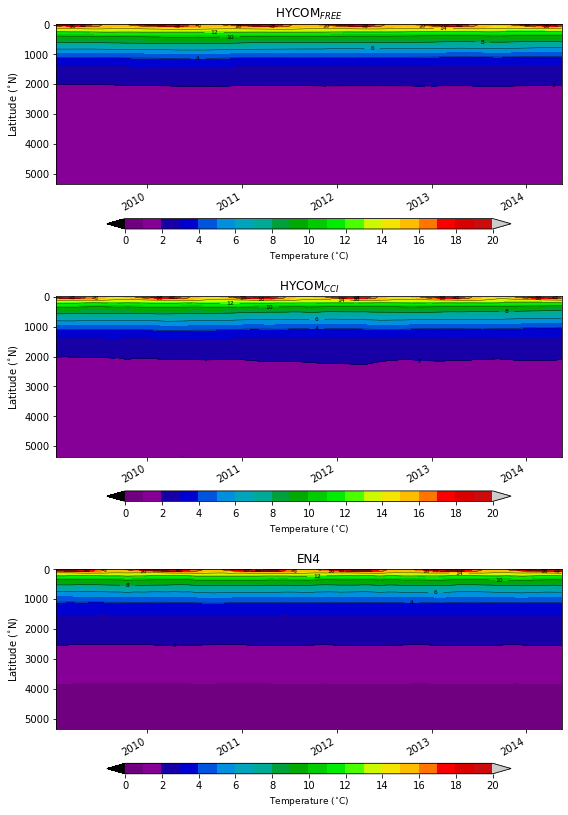

In [26]:
cci_temp_mean = hycomcci_monthly['temperature'].mean(dim=('longitude','latitude'))
free_temp_mean = hycomfree_monthly['temperature'].mean(dim=('longitude','latitude'))
en4_temp_mean = (ds_EN4['temperature'].mean(dim=('lon','lat')) - 273.15)

hovs = [free_temp_mean, cci_temp_mean, en4_temp_mean]
names = ['HYCOM$_{FREE}$', 'HYCOM$_{CCI}$', 'EN4']

fig = plt.figure(figsize=(8,11.5))
# fig.suptitle('Mean temperature Hovmoller')

cbarticks=np.arange(0,21,1)

for s, i in enumerate(hovs):
    
    ax = plt.subplot(3,1,s+1)
    
    img = i.plot.contourf(x='time', levels=cbarticks, cmap='nipy_spectral', add_colorbar=False, extend='both')
    contours = i.plot.contour(x='time', levels=cbarticks[::2], linewidths=0.4, colors='k', alpha=1)
    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
    plt.ylim(-20,)
    ax.invert_yaxis()
    cbar = plt.colorbar(img, ticks=cbarticks[::2], shrink=0.8, extend='both', orientation='horizontal', aspect=35)
    cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
    ax.set_title('{0}'.format(names[s]))
    plt.ylabel('Latitude ($^{\circ}$N)')
    plt.xlabel('')
    
plt.savefig('../Figures/hovmoller/Temp_mean_all_domain.png.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## Salinity

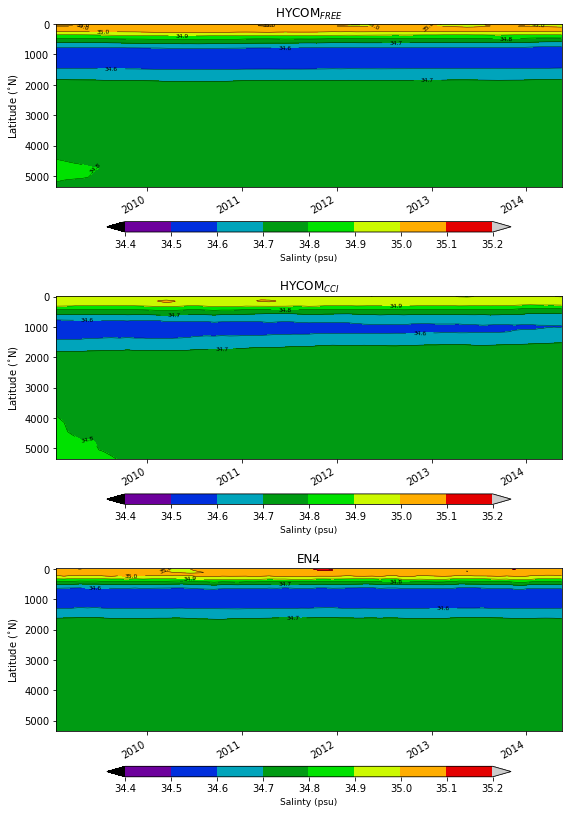

In [30]:
cci_sal_mean = hycomcci_monthly['salinity'].mean(dim=('longitude','latitude'))
free_sal_mean = hycomfree_monthly['salinity'].mean(dim=('longitude','latitude'))
en4_sal_mean = ds_EN4['salinity'].mean(dim=('lon','lat'))

hovs = [free_sal_mean, cci_sal_mean, en4_sal_mean]
names = ['HYCOM$_{FREE}$', 'HYCOM$_{CCI}$', 'EN4']

fig = plt.figure(figsize=(8,11.5))
# fig.suptitle('Mean temperature Hovmoller')

cbarticks=np.arange(34.4,35.3,0.1)

for s, i in enumerate(hovs):
    
    ax = plt.subplot(3,1,s+1)
    
    img = i.plot.contourf(x='time', levels=cbarticks, cmap='nipy_spectral', add_colorbar=False, extend='both')
    contours = i.plot.contour(x='time', levels=cbarticks[:], linewidths=0.4, colors='k', alpha=1)
    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.1f')
    plt.ylim(-20,)
    ax.invert_yaxis()
    cbar = plt.colorbar(img, ticks=cbarticks[:], shrink=0.8, extend='both', orientation='horizontal', aspect=35)
    cbar.set_label('Salinty (psu)', fontsize=9)
    ax.set_title('{0}'.format(names[s]))
    plt.ylabel('Latitude ($^{\circ}$N)')
    plt.xlabel('')
    
plt.savefig('../Figures/hovmoller/Sal_mean_all_domain.png.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()